# CS6700 : Tutorial 1 - Multi-Arm Bandits

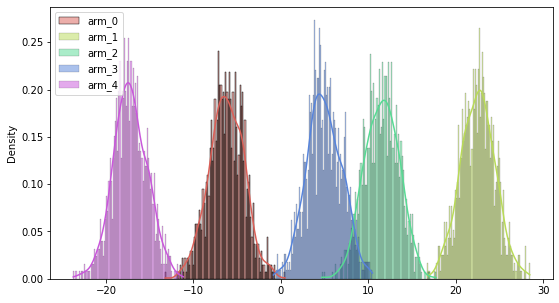

        Goal: Analysis 3 types of sampling strategy in a MAB

### Import dependencies

In [1]:
#!pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, List
import random
import math
import operator
import decimal

### Gaussian Bandit Environment

In [2]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)
  
  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [3]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates 
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [4]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

In [5]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    #na denotes the number of times action a has been picked so far
    na = self.num_pulls_per_arm[arm_id]
    #updating the estimate of reward
    self.Q[arm_id] = (arm_reward + (self.Q[arm_id])*na)/(na+1)
    #updating the value of na
    self.num_pulls_per_arm[arm_id] +=1
    pass

  def select_arm(self) -> int:
    # your code for selecting arm based on epsilon greedy policy
    epsilon = self.epsilon
    p = random.random()
    #generating a random number between 0 and 1
    if p < epsilon:
      arm = np.random.choice(self.arm_ids)
      #choosing a random choice with a probability of epsilon
    else:
      d = self.Q
      arm = max(d, key= lambda x: d[x])
      #choosing the best arm according to current q values with a probability 1- epsilon
    return arm
    

In [6]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'
  
  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    #na denotes the number of times action a has been picked so far
    na = self.num_pulls_per_arm[arm_id]
    #updating the estimate of reward
    self.Q[arm_id] = (arm_reward + (self.Q[arm_id])*na)/(na+1)
    #updating the value of na
    self.num_pulls_per_arm[arm_id] +=1
    pass

  def select_arm(self) -> int:
    # your code for selecting arm based on softmax policy
    #calculating the probabilites using softmax - "Probability" dictionary denotes the probability to pick each arm
    P = {id : decimal.Decimal(2.718)**(decimal.Decimal(self.Q[id])/decimal.Decimal(self.tau)) for id in self.Q.keys()}
    deno = sum(P.values())
    Probability = {id : P[id]/deno for id in P.keys()}
    Probability = dict(sorted(Probability.items(), key=operator.itemgetter(1)))
    #generating a random number r between 0 and 1
    r =  random.random()
    cumsum = 0
    for k in Probability.keys():
      cumsum = cumsum + Probability[k]
      if cumsum > r:
        return k
      #k denotes the arm that has been picked  
    return k



    pass 

In [7]:

class UCB(BasePolicy):
  # your code here
  def __init__(self,arm_ids,env,c):
    self.env = env
    self.arm_ids = arm_ids
    #initialising Q values and number of times arm has been pulled
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
    self.c = c

  @property
  def name(self):
    return f'UCB c:{self.c}'
  
  def reset(self):
    #reset
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    #na denotes the number of times action a has been picked so far
    na = self.num_pulls_per_arm[arm_id]
    #updating the estimate of reward
    self.Q[arm_id] = (arm_reward + (self.Q[arm_id])*na)/(na+1)
    #updating the value of na
    self.num_pulls_per_arm[arm_id] +=1
    pass

  def select_arm(self) -> int:
    # UCB algorithm
    c=self.c
    #first in UCB, we have to pick each arm atleast once to get initial reward value estimates
    #check if there is any arm that hasnt been picked even once, if such arm exists, play that arm
    for id in self.arm_ids:
      if self.num_pulls_per_arm[id] < 1:
        self.num_pulls_per_arm[id] = 1
        self.Q[id] = self.env.step(id) 
        return id
    #pick the arm that has the maximum possible upper bound according to the function below
    maximise_fn= {id: (self.Q[id]+c*(math.sqrt((math.log(self.num_pulls_per_arm[id]))/sum(self.num_pulls_per_arm)))) for id in self.arm_ids }
    arm = max(maximise_fn, key= lambda x: maximise_fn[x])
    #choose the arm - denotes by "arm"
    return arm
    pass 

#### Trainer

In [8]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward 


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward
 

  # calculate avg policy reward from policy_reward_each_run
  
  avg_policy_rewards = [0 for i in range(timesteps)] # your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = None # your code here (type: float)
  
  for i in range(len(policy_reward_each_run[0])):
      sum = 0
      for j in range(len(policy_reward_each_run)):
        sum = sum+ policy_reward_each_run[j][i]
      avg_policy_rewards[i] = sum/(num_runs)

  total_policy_regret = float(expected_max_reward)*(timesteps) - np.sum(avg_policy_rewards) 



  return avg_policy_rewards, total_policy_regret

In [9]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)
  
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')
  
  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

### Experiments

In [10]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

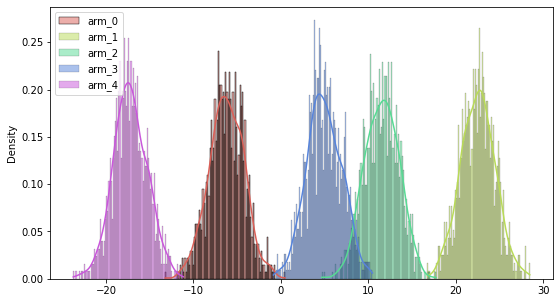

In [11]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [12]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [13]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


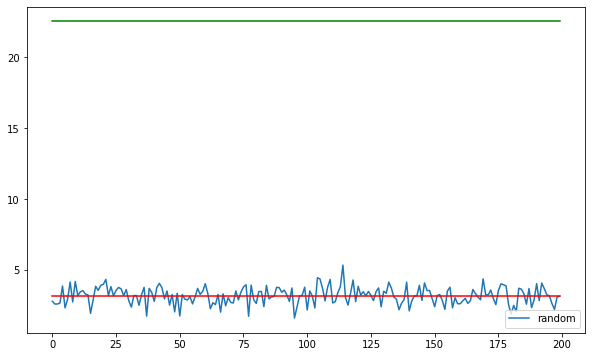

In [14]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 33.196
regret for ep-greedy ep:0.01: 80.125
regret for ep-greedy ep:0.5: 1984.890
regret for ep-greedy ep:0.9: 3491.271


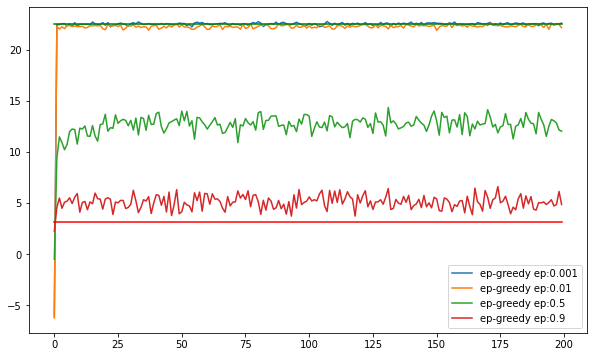

In [15]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1982.705
regret for softmax tau:1.0: 1320.198
regret for softmax tau:5.0: 401.754
regret for softmax tau:50.0: 3153.074


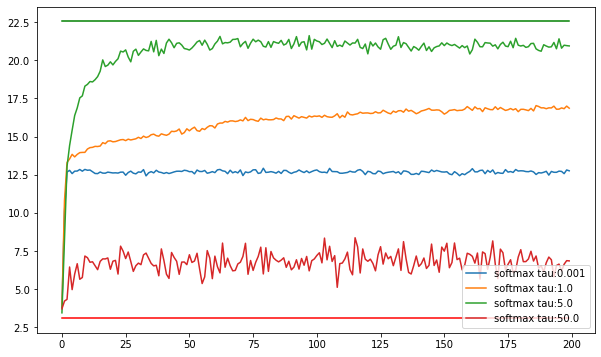

In [16]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB c:4: 99.218


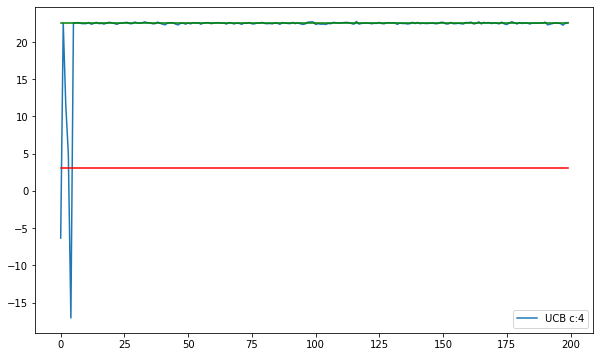

In [17]:
plot_reward_curve_and_print_regret(env, [UCB(env.arm_ids,env,4)], timesteps=200, num_runs=500)

#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.

regret for UCB c:2: 97.415
regret for UCB c:1.424: 95.614
regret for UCB c:1: 97.038
regret for UCB c:3: 98.473


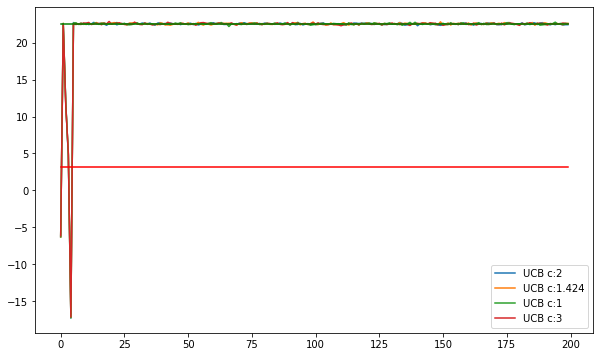

In [18]:
explore_ucb = [2,1.424,1,3]
ucb_policy = [UCB(env.arm_ids,env,k) for k in explore_ucb]
plot_reward_curve_and_print_regret(env, ucb_policy, timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 31.697
regret for ep-greedy ep:0.01: 103.759
regret for ep-greedy ep:0.1: 466.762
regret for ep-greedy ep:1: 3885.765
regret for ep-greedy ep:10: 3884.875


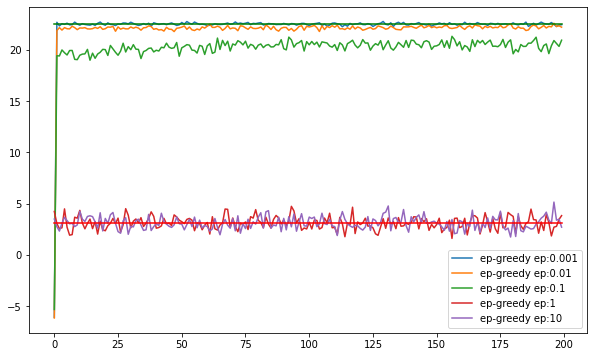

In [19]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.1, 1,10]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1945.507
regret for softmax tau:0.01: 1965.406
regret for softmax tau:0.1: 1926.360
regret for softmax tau:1: 1445.907
regret for softmax tau:10: 1207.146


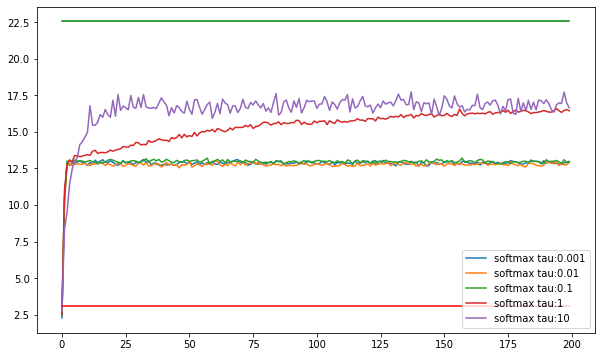

In [20]:
explore_softmax_taus =  [0.001, 0.01, 0.1, 1,10]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

Inference:

The UCB algorithm - first we have to play each arm atleast  once and get the estimates of rewards. This is included in the "timesteps".
I took the value of c = 4 in the original code. in the additional exercise - we have also tried for different other c values - 1.414 (root 2)
in Epsilon delta - more is the value of epsilon, more is the randomness in selection of an arm.
in softmax - more is the value of temperature parameter - more is the randomness.

In [21]:
"""This assignment is done by - Anirud N - CE21B014 - CS6700 - REINFORCEMENT LEARNING - TUTORIAL 1"""

'This assignment is done by - Anirud N - CE21B014 - CS6700 - REINFORCEMENT LEARNING - TUTORIAL 1'